# Testing for Rabbits

## Configuration for Rabbits

- 16 compute nodes -> 1 rabbit node
- 1 rabbit node -> 18 KIOXIA KCM7DRJE1T92 Drives (28 TB)
- KIOXIA KCM7DRJE1T92 -> PCIe Gen5 Controller with 4x dual channel (total 8x) Peak Write BW for seq access is 3.5GB/s and read is 14GB/s [link](https://americas.kioxia.com/en-us/business/ssd/enterprise-ssd/cm7-r-e3s.html)

- Total Write BW per rabbit node is 3.5 * 18 = 65 GB/s
- We should get best bandwidth around 8 PPN per node with maximum at 18 * 8. But as i would be scaling in power of 2. I expect the max to reach at 16 * 8. 

## Current Test Cases (10/16/24)
- Write only and FPP with and without Fsync.

In [147]:
import dask.dataframe as dd
import dask.bag as db
import matplotlib.pyplot as plt
from glob import glob
import numpy as np

In [165]:
project_path="/usr/workspace/haridev/rabbits"
results = [
        {
        "case": {"ps": "fpp", "workload": "wo", "bs":"4GB", "ts":"1m"},
        "ppn": [1-96],
        "nodes": [1-16],
        "rabbit": 1,
        "fs_type": "xfs",
        "logs":[f"{project_path}/benchmarks/ior/output/xfs/ior-20241015160107/result/*.csv",
                f"{project_path}/benchmarks/ior/output/xfs/ior-20241015162611/result/*.csv",
                f"{project_path}/benchmarks/ior/output/xfs/ior-20241015144913/result/*.csv",
                f"{project_path}/benchmarks/ior/output/xfs/ior-20241015130504/result/*.csv",]
        },
        { "case": {"ps": "fpp", "workload": "wo", "sync": "1", "bs":"4GB", "ts":"1m"},
            "ppn": [1-64],
            "nodes": [1-16],
            "rabbit": 1,
            "fs_type": "xfs",
            "logs":[f"{project_path}/benchmarks/ior/output/xfs/ior-20241014182525/result/*.csv",
                    f"{project_path}/benchmarks/ior/output/xfs/ior-20241014184458/result/*.csv",
                    f"{project_path}/benchmarks/ior/output/xfs/ior-20241014184928/result/*.csv",
                    f"{project_path}/benchmarks/ior/output/xfs/ior-20241014185601/result/*.csv",
                    f"{project_path}/benchmarks/ior/output/xfs/ior-20241014190055/result/*.csv",
                    f"{project_path}/benchmarks/ior/output/xfs/ior-20241014190713/result/*.csv",
                    f"{project_path}/benchmarks/ior/output/xfs/ior-20241014191819/result/*.csv",
                    f"{project_path}/benchmarks/ior/output/xfs/ior-20241014191819/result/*.csv",
                    f"{project_path}/benchmarks/ior/output/xfs/ior-20241014194044/result/*.csv",
                    f"{project_path}/benchmarks/ior/output/xfs/ior-20241014200912/result/*.csv",
                    f"{project_path}/benchmarks/ior/output/xfs/ior-20241014204803/result/*.csv",
                    f"{project_path}/benchmarks/ior/output/xfs/ior-20241014225041/result/*.csv",
                    f"{project_path}/benchmarks/ior/output/xfs/ior-20241015163657/result/*.csv",]
    
        },
        { "case": {"ps": "fpp", "workload": "wo", "bs":"16GB", "ts":"1m"},
        "ppn": [8-64],
        "nodes": [1-16],
        "rabbit": 1,
        "fs_type": "xfs",
        "logs":[f"{project_path}/benchmarks/ior/output/xfs/ior-20241015170137/result/*.csv",
                f"{project_path}/benchmarks/ior/output/xfs/ior-20241015180831/result/*.csv",
                f"{project_path}/benchmarks/ior/output/xfs/ior-20241015185311/result/*.csv",
                f"{project_path}/benchmarks/ior/output/xfs/ior-20241015210951/result/*.csv",
                f"{project_path}/benchmarks/ior/output/xfs/ior-20241015213807/result/*.csv",]
        },
        { "case": {"ps": "fpp", "workload": "wo", "sync": "1", "bs":"16GB", "ts":"1m"},
        "ppn": [8-64],
        "nodes": [1-16],
        "rabbit": 1,
        "fs_type": "xfs",
        "logs":[f"{project_path}/benchmarks/ior/output/xfs/ior-20241015191529/result/*.csv",
                f"{project_path}/benchmarks/ior/output/xfs/ior-20241015214240/result/*.csv",
                f"{project_path}/benchmarks/ior/output/xfs/ior-20241015214921/result/*.csv",
                f"{project_path}/benchmarks/ior/output/xfs/ior-20241015223344/result/*.csv",
                f"{project_path}/benchmarks/ior/output/xfs/ior-20241015223546/result/*.csv",
                f"{project_path}/benchmarks/ior/output/xfs/ior-20241015231720/result/*.csv"]
        }
]

In [166]:
def get_case(data):
    case_str=""
    total_char=len(data["case"])
    char_index=0
    for key, value in data["case"].items():
        case_str+=key+ "-" + value
        if char_index < total_char - 1:
            case_str+="_"
        char_index+=1
    return case_str
def percentile(n):
    return dd.Aggregation(
        name='percentile_{:02.0f}'.format(n*100),
        # this computes the median on each partition
        chunk=lambda s: s.quantile(n),
        # this combines results across partitions; the input should just be a list of length 1
        agg=lambda s0: s0.quantile(n),
    )
median_fun = dd.Aggregation(
    name="median",
    # this computes the median on each partition
    chunk=lambda s: s.median(),
    # this combines results across partitions; the input should just be a list of length 1
    agg=lambda s0: s0.median(),
)
def get_logs(logs):
    final_logs = []
    for log in logs:
        final_logs.extend(glob(log))
    return final_logs
def map_text(val):
    text, file = val
    d = {}
    if "access" not in text:
        values = file.split("_")
        d["node"]=int(values[1])
        d["ppn"]=int(values[2])
        d["id_str"]=values[1] + "-" + values[2]
        values = text.split(",")
        d["access"] = values[0]
        d["bw_mbps"] = float(values[1])
        d["iops"] = float(values[2])
        d["lat"] = float(values[3])
        d["block_kb"] = float(values[4])
        d["ts_kb"] = float(values[5])
        d["open_sec"] = float(values[6])
        d["rd_wr_sec"] = float(values[7])
        d["close_sec"] = float(values[8])
        d["total_sec"] = float(values[9])
        d["num_tasks"] = int(values[10])
        d["iter"] = int(values[11])
    return [d]

Case 0 ps-fpp_workload-wo_bs-4GB_ts-1m


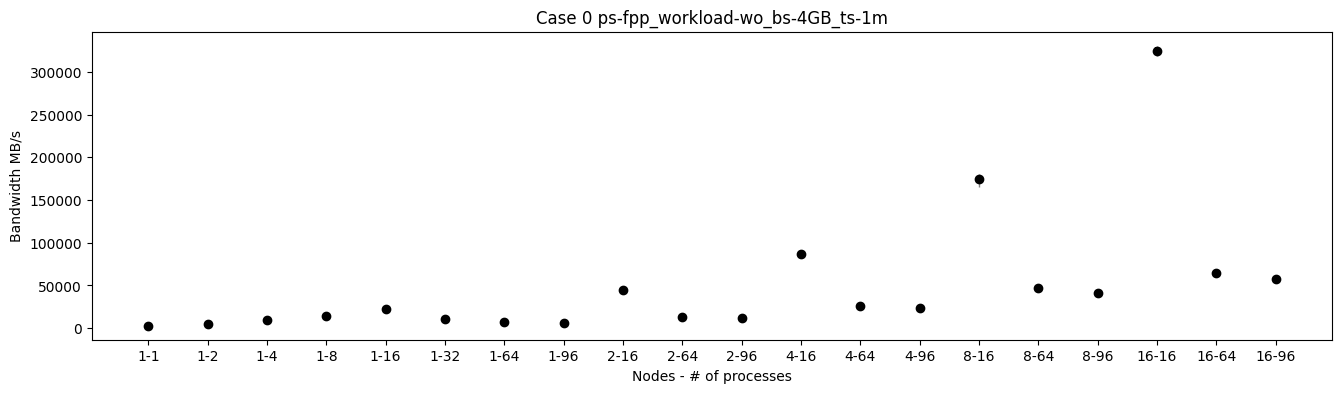

Case 1 ps-fpp_workload-wo_sync-1_bs-4GB_ts-1m


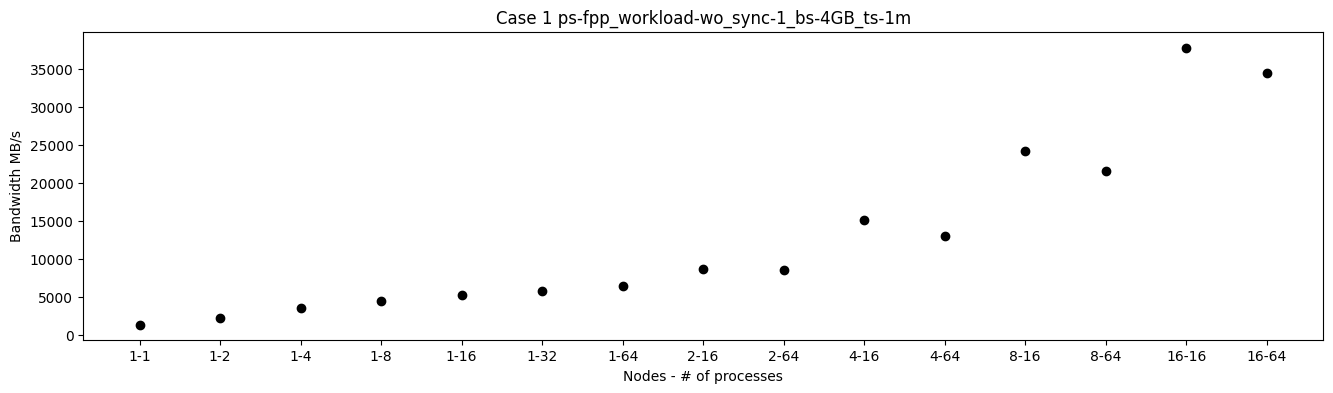

Case 2 ps-fpp_workload-wo_bs-16GB_ts-1m


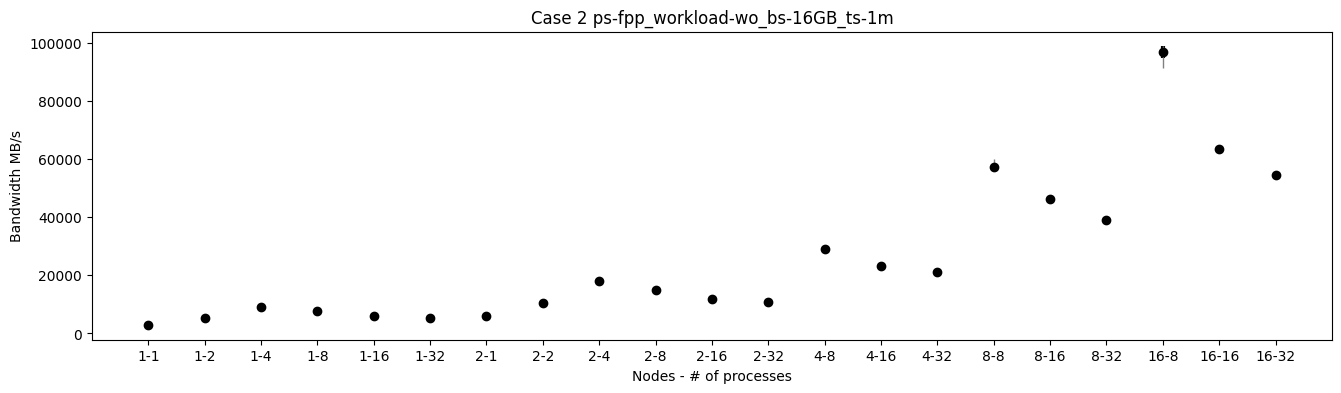

Case 3 ps-fpp_workload-wo_sync-1_bs-16GB_ts-1m


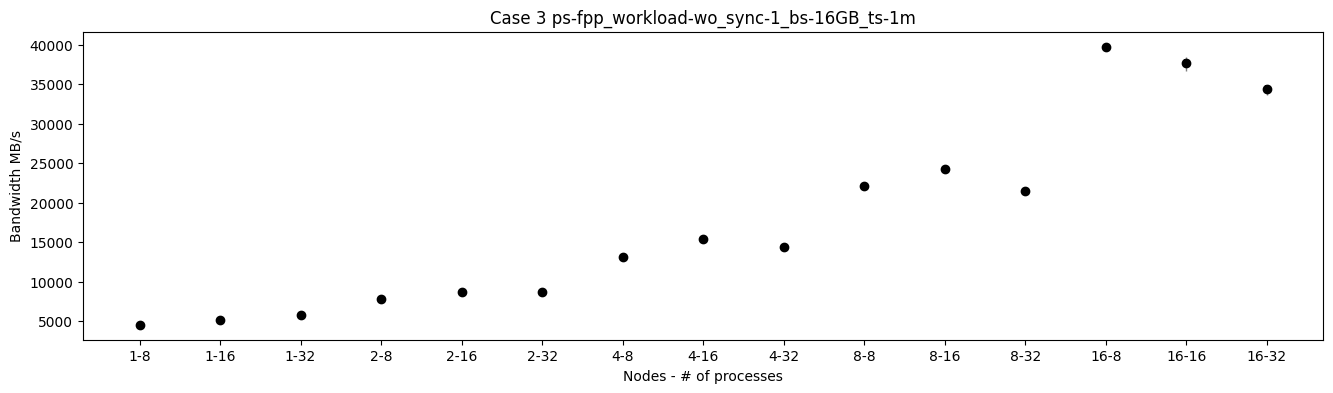

In [167]:
for index, result in enumerate(results):
    current_case_str = get_case(result)
    current_case_str=f"Case {index} {current_case_str}"
    print(current_case_str)
    logs = get_logs(result["logs"])
    main_bag = db.read_text(logs, include_path=True).map(map_text).flatten().filter(lambda x: "access" in x)
    columns = {'id': "uint64[pyarrow]", 'id_str': "string[pyarrow]", 'node': "uint16[pyarrow]", 'ppn': "uint16[pyarrow]",
               'access': "string[pyarrow]", 'bw_mbps': "float32[pyarrow]", 'iops': "float32[pyarrow]", 'lat': "float32[pyarrow]",
               'block_kb': "float32[pyarrow]", 'ts_kb': "float32[pyarrow]",
               'open_sec': "float32[pyarrow]", 'rd_wr_sec': "float32[pyarrow]", 'close_sec': "float32[pyarrow]", 'total_sec': "float32[pyarrow]",
               'num_tasks': "uint16[pyarrow]", 'iter': "uint16[pyarrow]"}
    ddf = main_bag.to_dataframe(meta=columns)
    data = ddf[["node","ppn","id_str","iter","bw_mbps"]].groupby(["node","ppn"]).agg({"id_str":"first", "bw_mbps":[sum, "mean", median_fun, min, max, "std", percentile(.25), percentile(.75)]}).compute()
    # print(data)
    data = data.reset_index().sort_values(["node", "ppn"])
    plt.figure(figsize=(16,4))
    plt.errorbar(data[("id_str", "first")], data[("bw_mbps", "mean")], data[("bw_mbps", "std")], fmt='ok', lw=3)
    plt.errorbar(data[("id_str", "first")], data[("bw_mbps", "mean")], [data[("bw_mbps", "mean")] - data[("bw_mbps", "min")], data[("bw_mbps", "max")] - data[("bw_mbps", "mean")]],
                fmt='.k', ecolor='gray', lw=1)
    plt.xticks(data[("id_str", "first")], labels = data[("id_str", "first")])
    plt.title(current_case_str)
    plt.xlabel("Nodes - # of processes")
    plt.ylabel("Bandwidth MB/s")
    plt.show()


## Next Questions (10/16/24)
- How is the Drives divided between the node? Do we expect interference between jobs? How does capacity requested relate to drive allocated?
- Performance for 2 rabbit node scaling.

64 GB allocation -> 16 drives -> 4 GB How is the striping of allocated size across Drives happens?
sweet spot is 1 TB probably for Lustre

16 * 32 ()